In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE = 'travistorrent_11_1_2017.csv'

In [3]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_build_started_at',
                                                         'tr_log_num_tests_ok',        
                                                         'tr_log_num_tests_failed' ,   
                                                         'tr_log_num_tests_skipped'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',
                                                                                            'gh_build_started_at': 'category',
                                                                                            'tr_log_num_tests_ok': np.float32,
                                                                                            'tr_log_num_tests_failed': np.float32,
                                                                                            'tr_log_num_tests_skipped': np.float32}, encoding='utf-8')


In [4]:
#df_ruby = dataset.dropna() # Remove as linhas NAN
#df_ruby['date'], df_ruby['hours'] = df_ruby.gh_pushed_at.str.split(' ').str # Separa a coluna que possui data e hora em duas novas colunas de data hora

<font size = 4/>
* Filtro de Linguagem

In [5]:
def language_filter(language):
    projects = dataset.drop_duplicates(['gh_project_name']) #Remove nomes duplicados 
    projects = projects.loc[projects['gh_lang'] == language] #Filtra apenas linguagem X
    projects = projects.gh_project_name #Cria uma Serie com nomes unicos dos projetos
    
    return(projects)

<font size = 4/>
* Quantidade de commit por projeto

In [6]:
def commit_flow(projects):
    list_project = []
    list_commit = []
    
    for project_name in projects:
        
        df = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto

        df = df.drop_duplicates(['tr_build_id'])# Remove linhas duplicadas
        
        num_commit = df.gh_num_commits_in_push.sum()# Soma de todos push
        
        list_commit.append(num_commit) # Lista com total de commit de cada projeto
        
        list_project.append(project_name)# Lista com o Nome de cada projeto
        
    return(list_commit, list_project)

<font size = 4/>
* Frequência do projeto

In [20]:
def project_frequency(list_commit, list_project):

    df = pd.DataFrame(list_commit)
    df = df.describe() # Se obtem o primeiro, segundo e terceiro quartil
    
    # lista de frequencias
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    veryHigh_frequency = []
    
    for i in range(len(list_commit)):
        
        if(list_commit[i] <= df[0][4]): #Ate o Primeiro quartil
            low_frequency.append(list_commit[i])
            
        elif(list_commit[i] <= df[0][5]): #Ate a Mediana
            medium_frequency.append(list_commit[i])
            
        elif(list_commit[i] <= df[0][6]): #Ate o terceiro quartil
            high_frequency.append(list_commit[i])
        
        else: #Acima do terceiro quartil
            veryHigh_frequency.append(list_commit[i])
            
    return(low_frequency, medium_frequency, high_frequency, veryHigh_frequency)

In [8]:
language_name = ['java', 'ruby', 'javascript'] #Linguagens presentes

commit_project = []
project_name = []

for language in language_name:
    
    project = language_filter(language) # Filtra os projetos com a linguagem escolhida
    
    list_commit, list_project = commit_flow(project) # Retorna duas listas, uma com total de commit de cada projeto e outra com o nome de cada projeto
    
    commit_project.append(list_commit) # Adiciona em uma lista os commits
    
    project_name.append(list_project) # Adiciona em uma lista os nomes dos projetos


In [92]:
low = np.array([[],])
for i in range(len(commit_project)):
    low, medium, high, veryHigh = project_frequency(commit_project[i], project_name[i])

[252.0]

In [86]:
def plot(low, medium, high, veryHigh):
    fig, axs = plt.subplots(2, 2)

    # Low plot
    axs[0, 0].boxplot(low)
    axs[0, 0].set_title('Low')

    # Medium plot
    axs[0, 1].boxplot(medium)
    axs[0, 1].set_title('Medium')
    
    # High plot
    axs[1, 0].boxplot(high)
    axs[1, 0].set_title('High')
    
    # Very High plot
    axs[1, 1].boxplot(veryHigh)
    axs[1, 1].set_title('Very High')
    
    # Space
    fig.subplots_adjust(left=0.08, right=1.98, bottom=0.05, top=1.9,
                        hspace=0.4, wspace=0.3)

<font size = 4/>
* Plot de todos os commits, usando java, ruby e javascript

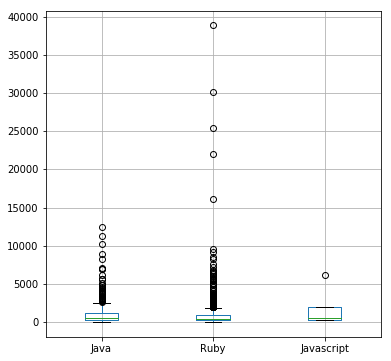

In [10]:
df = pd.DataFrame([('Java', commit_project[0]),
                   ('Ruby', commit_project[1]),
                   ('Javascript', commit_project[2])], columns=['Language', 'commit']).set_index('Language')

df['commit'].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(6,6),rot=0)


Text(0.5,1,'veryHigh')

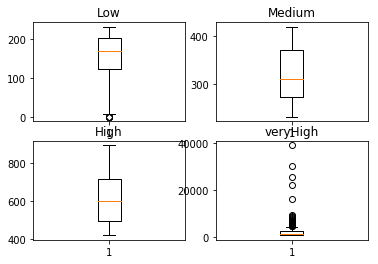

In [61]:
plt.figure()

plt.subplot(2,2,1)
plt.boxplot(low)
plt.title('Low')

plt.subplot(2,2,2)
plt.boxplot(medium)
plt.title('Medium')

plt.subplot(2,2,3)
plt.boxplot(high)
plt.title('High')

plt.subplot(2,2,4)
plt.boxplot(veryHigh)
plt.title('veryHigh')